# Labeling a full WSI using stardist and dask for distributed computation

## Load the test image

In [14]:
import sys
sys.path.insert(0, "..")

In [15]:
import relabeling

In [25]:
import numpy as np
import zarr
import dask.array as da
import matplotlib.pyplot as plt

Segment and label a full image of a mouse embryo from the Image Data Repository (IDR) https://idr.github.io/ome-ngff-samples/

In [26]:
file_url = "https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.1/6001253.zarr"
z_arr = zarr.open(file_url, mode="r")

Visualize the image DAPI staining channel

In [27]:
z_arr["0"].info

Name,/0
Type,zarr.core.Array
Data type,>u2
Shape,"(1, 2, 297, 1024, 803)"
Chunk shape,"(1, 1, 1, 1024, 803)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,976859136 (931.6M)
Chunks initialized,0/594


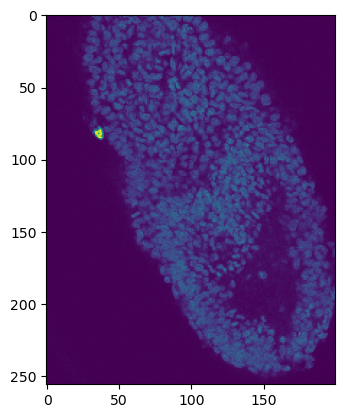

In [28]:
plt.imshow(z_arr["2"][0, 1, 100, ...])

## Load the StarDist models

In [29]:
# Dimension reduction and clustering libraries
from stardist.models import StarDist2D
from csbdeep.utils import normalize

def stardist2d(im_chunk, model=None):
    labeled_image, _ = model.predict_instances(normalize(im_chunk, 1,99.8, axis=(0, 1)))
    return labeled_image

model_2D = StarDist2D.from_pretrained("2D_demo")

Found model '2D_demo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.486166, nms_thresh=0.5.


## Open the image lazily using Dask

Segment the slice at Z=100 using the DAPI channel.

In [34]:
img_da = da.from_zarr(file_url, component="0")
img_da = img_da[0, 1, 100, ...]
img_da = da.rechunk(img_da, (256, 256))
img_da

dask.array<rechunk-merge, shape=(1024, 803), dtype=>u2, chunksize=(256, 256), chunktype=numpy.ndarray>

## Execute the segmentation and relabeling process

In [35]:
%%time
labels = relabeling.label(
    img_da,
    seg_fn=stardist2d,
    mask=None,
    mask_scale=1.0,
    overlap=50,
    ndim=2,
    persist=".",
    progressbar=True,
    segmentation_fn_kwargs={"model": model_2D}
)

[########################################] | 100% Completed | 5.40 sms
[########################################] | 100% Completed | 929.87 ms
[########################################] | 100% Completed | 462.26 ms
CPU times: total: 21.4 s
Wall time: 7.18 s


In [36]:
labels

dask.array<getitem, shape=(1024, 1024), dtype=int32, chunksize=(256, 256), chunktype=numpy.ndarray>

N labels: 758 (757)


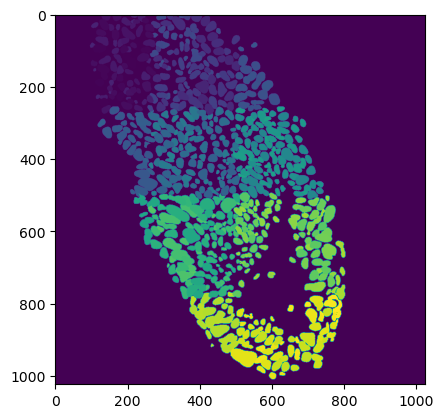

In [37]:
plt.imshow(labels)
print(f"N labels: {np.unique(labels).compute().size} ({labels.max().compute()})")